In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、すべて全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

In [2]:
class Affine:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.init_W(n_nodes1, n_nodes2)
        self.B = initializer.init_B(n_nodes2)
        
        # Adagradで使用する各層の前回までの重み
        self.H_before_W = np.zeros_like(self.W)
        self.H_before_B = np.zeros_like(self.B)
    
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """       
        # 逆伝播で使用するためインスタンス化
        self.X = X
        
        A = X @ self.W + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dB = dA.sum(axis=0)
        self.dW = self.X.T @ dA
        dZ = dA @ self.W.T
        
        # 更新
        # ここの書き方がよくわかってない
        self = self.optimizer.update(self)
        
        return dZ

# 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
        
    def init_W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W : 重みの初期値
        """
        W = np.random.randn(n_nodes1, n_nodes2) * self.sigma
        return W


    def init_B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :　バイアスの初期値
        """
        B = np.zeros(n_nodes2)
        return B

# 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        """
        Wの更新
        
        param
        --------------
        layer : 更新前の層のインスタンス
        --------------
        
        return
        ---------------
        layer : 更新後の層のインスタンス
        """
        
        # 引数のメンバ値を更新する
        layer.W -= self.lr * layer.dW 
        layer.B -= self.lr * layer.dB 
        
        return layer

# 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。


発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

In [5]:
class Sigmoid:
    """
    sigmoid関数
    """
    
    
    def forward(self, A):
        """
        順伝播
        """
        Z = 1 / (1 + np.exp(-A))
        
        # 逆伝播でつかうためインスタンス化
        self.Z = Z
        
        return Z
    
    
    def backward(self, dZ):
        """
        逆伝播
        """
        dA = dZ * (self.Z * (1 - self.Z))
        
        return dA
        

In [16]:
class Tanh:
    """
    tanh関数
    """
    
    
    def forward(self, A):
        """
        順伝播
        """
        Z = np.tanh(A)
        
        # 逆伝播でつかうためインスタンス化
        self.Z = Z
        
        return Z
    
    
    def backward(self, dZ):
        """
        逆伝播
        """
        dA = dZ * (1 - self.Z ** 2)
        
        return dA
    

In [6]:
class Softmax:
    """
    softmax関数
    """
    
    
    def forward(self, A):
        """
        順伝播
        """
        Z = np.exp(A) / np.exp(A).sum(axis=1).reshape(-1, 1)
        
        # 逆伝播でつかうためインスタンス化
        self.Z = Z
        
        return Z
    
    
    def backward(self, y):
        """
        逆伝播
        """
        # 交差エントロピー誤差層の逆伝播+softmax層の逆伝播
        
        dA = 1 / y.shape[0] * (self.Z - y)
        
        return dA
  

# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。


$$f(x) = ReLU(x) = \begin{cases} x & \text{if $x>0$,}\\ 0 & \text{if $x\leqq0$.} \end{cases}$$
$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。


$$\frac{\partial f(x)}{\partial x} = \begin{cases} 1 & \text{if $x>0$,}\\ 0 & \text{if $x\leqq0$.} \end{cases}$$
数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [104]:
class ReLU:
    """
    LeRU関数
    """
    
    
    def forward(self, A):
        """
        順伝播
        """
        self.A = A
        Z = np.maximum(0, A)
        
        return Z
    
    
    def backward(self, dZ):
        """
        逆伝播
        """
        dA = dZ * np.where(self.A > 0, 1, 0)
        
        return dA
        

# 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。


Xavierの初期値
Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$\sigma = \frac{1}{\sqrt{n}}$$
$n$ : 前の層のノード数

Heの初期値
Heの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$\sigma = \sqrt{\frac{2}{n}}$$

$n$ : 前の層のノード数



In [7]:
class XavierInitializer:
    
    
    def init_W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W : 重みの初期値
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    
    def init_B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :　バイアスの初期値
        """
        B = np.zeros(n_nodes2)
        return B


In [8]:
class HeInitializer:

    def init_W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W : 重みの初期値
        """
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W

    def init_B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :　バイアスの初期値
        """
        B = np.zeros(n_nodes2)
        return B

# 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

$$W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i})B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的にはすべて同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。

$$H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i})$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した $H_i$

In [9]:
class AdaGrad:
    """
    各FC層の重み及びバイアスの更新
    
    param
    -------------
    lr : 学習率
    
    """
    
    def __init__(self, lr):
        self.lr = lr
        self.delta = 1e-7
    
    def update(self, layer):
        """
        Wの更新
        
        param
        --------------
        layer : FCクラスのインスタンス
        --------------
        
        return
        ---------------
        layer : FCクラスのインスタンス
        """
        
        
        hW = layer.H_before_W + (layer.dW * layer.dW)
        # h.shape = dw.shape = w.shape
        
        layer.W -= self.lr * layer.dW / np.sqrt(hW + self.delta)
        # 割り算なのでdW / hは形が変わらないはず(掛け算であればアダマール積を取る。)
        # そもそも行列割り算という概念がないため、割り算は同じ形じゃないとできない
        
        layer.H_before_W = hW
        # 次使う場合のためにhは更新する
                 
        hB = layer.H_before_B + (layer.dB * layer.dB)
        
        layer.B -= self.lr * layer.dB / np.sqrt(hB + self.delta)
        
        layer.H_before_B = hB
        # 次使う場合のためにhは更新する
        
        return layer

## データ読み込み

In [10]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像データ→行データ
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train /= 255
X_test /= 255

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# one-hotのデータ分割
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, stratify=y_train_one_hot, test_size=0.2, random_state=0)

# 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [11]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # ceilは切り上げ関数
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    
    # len関数が使われるとこの値を返す。
    def __len__(self):
        return self._stop
    
    # 要素をインスタンス変数に入れると値を返す
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    # iterが使われるとこの値を返す、なんでselfそのものを返す？？
    # そういう物っぽい、nextと組み合わせて使われる
    # for分繰り返されるという訳ではなく、forを行う前に一度だけ実行される
    def __iter__(self):
        self._counter = 0
        return self
    
    # forの回数実行される
    def __next__(self):
        # 要素の終わりまでいったら自動的に終了する
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [60]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

# 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください

## Initについて

### init : simple

In [61]:
Simple_sigmoid_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Simple_sigmoid_SGD.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

In [62]:
Simple_sigmoid_SGD.loss_train

array([1.73310936, 1.13322796, 0.81670393, 0.65747963, 0.56593595,
       0.50678239, 0.46539115, 0.43481903, 0.41129579, 0.39256824,
       0.37721154, 0.3642933 , 0.35318753, 0.34346413, 0.3348206 ,
       0.32703915, 0.31995927, 0.31345997, 0.30744805, 0.30185029])

In [63]:
Simple_sigmoid_SGD.loss_val

array([1.73684662, 1.13896586, 0.82381957, 0.66553995, 0.57471959,
       0.51636306, 0.47593326, 0.44647341, 0.42417318, 0.40674289,
       0.39273148, 0.38118905, 0.37147793, 0.36315985, 0.35592639,
       0.34955526, 0.34388251, 0.33878449, 0.334166  , 0.32995229])

0.9097


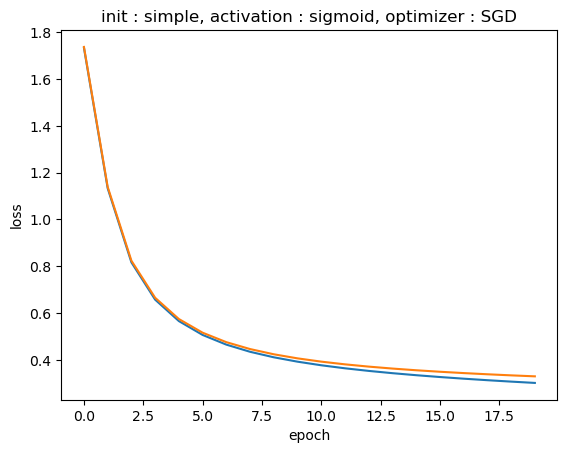

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, Simple_sigmoid_SGD.predict(X_test)))
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_train, label='train')
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_val, label='val')
plt.title('init : simple, activation : sigmoid, optimizer : SGD')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

### Init : Xavier

In [67]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
        self.activation1 = Sigmoid()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
        self.activation2 = Sigmoid()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

In [68]:
Xavier_sigmoid_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Xavier_sigmoid_SGD.fit(X_train[:10000], y_train_one_hot[:10000], X_val=X_val, y_val=y_val_one_hot)

### init : He

In [72]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, HeInitializer(), optimizer)
        self.activation1 = Sigmoid()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, HeInitializer(), optimizer)
        self.activation2 = Sigmoid()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, HeInitializer(), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

In [73]:
He_sigmoid_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
He_sigmoid_SGD.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

### 考察

In [78]:
print('init : Simple : {}'.format(accuracy_score(y_test, Simple_sigmoid_SGD.predict(X_test))))
print('init : Xavier : {}'.format(accuracy_score(y_test, Xavier_sigmoid_SGD.predict(X_test))))
print('init : He : {}'.format(accuracy_score(y_test, He_sigmoid_SGD.predict(X_test))))

init : Simple : 0.9097
init : Xavier : 0.8981
init : He : 0.9058


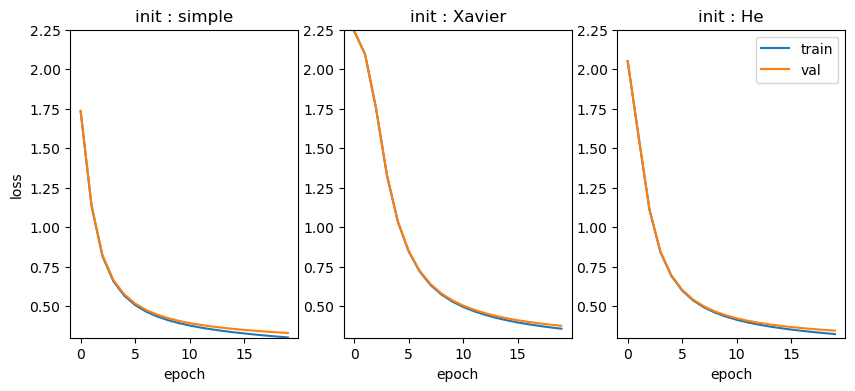

In [94]:
plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.ylim(0.3, 2.25)
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_train, label='train')
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_val, label='val')
plt.title('init : simple')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(132)
plt.ylim(0.3, 2.25)
plt.plot(np.arange(Xavier_sigmoid_SGD.epoch), Xavier_sigmoid_SGD.loss_train, label='train')
plt.plot(np.arange(Xavier_sigmoid_SGD.epoch), Xavier_sigmoid_SGD.loss_val, label='val')
plt.title('init : Xavier')
plt.xlabel('epoch')

plt.subplot(133)
plt.ylim(0.3, 2.25)
plt.plot(np.arange(He_sigmoid_SGD.epoch), He_sigmoid_SGD.loss_train, label='train')
plt.plot(np.arange(He_sigmoid_SGD.epoch), He_sigmoid_SGD.loss_val, label='val')
plt.title('init : He')
plt.xlabel('epoch')

plt.legend()
plt.show();

手持ちの本だと活性化関数がSigmoidの初期値はXavierにすることで誤差が正確に伝わると記載があった。  
しかしながら今回の結果だと、Xavierが最も収束が遅く損失関数も大きくなってしまった.  
原因としては
1. 訓練データが小さい  
2. epochが小さい  
3. 学習率が大きい  

のどれかだと思う

## Activateについて

In [95]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

### activater : sigmoid

In [96]:
Simple_sigmoid_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Simple_sigmoid_SGD.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

###  activeter : tanh

In [97]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

In [98]:
Simple_tanh_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Simple_tanh_SGD.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

### activeter : LeRU

In [105]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = ReLU()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = ReLU()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

In [106]:
Simple_ReLU_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Simple_ReLU_SGD.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

### 考察

In [107]:
print('activeter : sigmoid : {}'.format(accuracy_score(y_test, Simple_sigmoid_SGD.predict(X_test))))
print('activeter : tanh : {}'.format(accuracy_score(y_test, Simple_tanh_SGD.predict(X_test))))
print('activeter  : ReLU : {}'.format(accuracy_score(y_test, Simple_ReLU_SGD.predict(X_test))))

activeter : sigmoid : 0.91
activeter : tanh : 0.9474
activeter  : ReLU : 0.9534


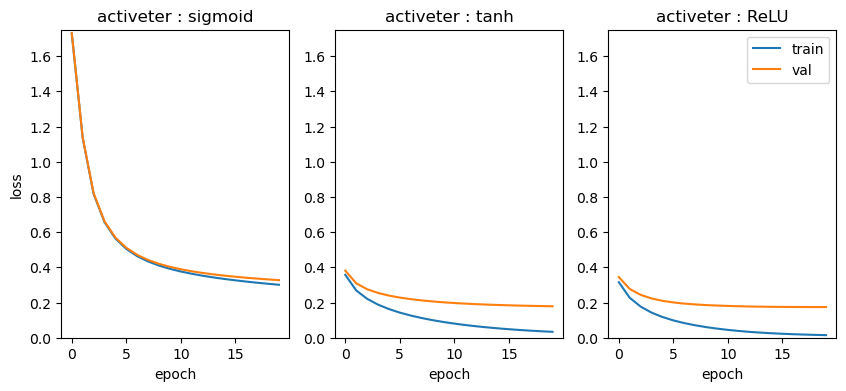

In [110]:
plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.ylim(0, 1.75)
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_train, label='train')
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_val, label='val')
plt.title('activeter : sigmoid')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(132)
plt.ylim(0, 1.75)
plt.plot(np.arange(Simple_tanh_SGD.epoch), Simple_tanh_SGD.loss_train, label='train')
plt.plot(np.arange(Simple_tanh_SGD.epoch), Simple_tanh_SGD.loss_val, label='val')
plt.title('activeter : tanh')
plt.xlabel('epoch')

plt.subplot(133)
plt.ylim(0, 1.75)
plt.plot(np.arange(Simple_ReLU_SGD.epoch), Simple_ReLU_SGD.loss_train, label='train')
plt.plot(np.arange(Simple_ReLU_SGD.epoch), Simple_ReLU_SGD.loss_val, label='val')
plt.title('activeter : ReLU')
plt.xlabel('epoch')

plt.legend()
plt.show();

参考書通りの結果となった。  
sigmoid以外は誤差が効率よく伝わり、過学習してしまった。  

## optimizier
### optimizer : SGD

In [111]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = SGD(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

In [112]:
Simple_sigmoid_SGD = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Simple_sigmoid_SGD.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

### optimizer : AdaGrad

In [113]:
class ScratchDeepNeuralNetrowkClassifier:
    
    
    def __init__(self, n_nodes1, n_nodes2, n_output, epoch=20, lr=0.02, sigma=0.1, verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        self.epoch : エポック数
        self.loss_train : 訓練データの損失
        self.loss_val : 検証データの損失
        self.verbose : 学習過程を表示するか
        """
        self.sigma = sigma
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.epoch = epoch
        self.loss_train = np.zeros(epoch)
        self.loss_val = np.zeros(epoch)
        self.verbose = verbose
        
        
    def get_loss(self, X, y_ture):
        """
        クロスエントロピー誤差を計算
        log(X)が最大値0の値を取るため-をかける必要がある。
        全て正解の場合0を取る。

        param
        -------------------
        X : 次の形のndarray(batch_size, n_features)
        入力値
        y_ture : 次の形のndarray(batch_size, n_class)
        正解ラベル

        return
        --------------------
        L : float(スカラー)
        """

        h = 1e-7      
        L = - np.sum(y_ture * np.log(X + h) / len(y_ture))
        return L
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        """
        
        # 1層目の入力特徴量数
        self.n_features = X.shape[1]
        
        # Affine, optimizer, initializerの決定
        # Affine :3層, optimizer : SGD, initializer : simple
        optimizer = AdaGrad(self.lr)
        self.Affine1 = Affine(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.Affine2 = Affine(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.Affine3 = Affine(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()      
        
        # エポック毎に更新
        for i in range(self.epoch):
            
            # バッチ処理を実行
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            
            #
            # バッチでループ
            #
            for mini_X_train, mini_y_train in get_mini_batch:

                # 順伝播
                A1 = self.Affine1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # 逆伝播
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.Affine3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.Affine2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Affine1.backward(dA1) # dZ0は使用しない
                
            #
            # 更新パラメータを使って全データで検証
            #
            A1 = self.Affine1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.Affine2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.Affine3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
            # lossの計算
            self.loss_train[i] = self.get_loss(Z3, y)
            
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('loss : {}'.format(self.loss_train[i]))
        
            # 検証データ
            if X_val is not None:
                #
                # 検証データの出力値を求める
                #
                A1 = self.Affine1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.Affine2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.Affine3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # lossの計算
                self.loss_val[i] = self.get_loss(Z3, y_val) 
            
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.Affine1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Affine2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.Affine3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(Z3, axis=1)

In [114]:
Simple_sigmoid_Adagrad = ScratchDeepNeuralNetrowkClassifier(n_nodes1=400, n_nodes2=200, n_output=10, verbose=False)
Simple_sigmoid_Adagrad.fit(X_train[:10000], y_train_one_hot[:10000],  X_val=X_val, y_val=y_val_one_hot)

###  考察

In [116]:
print('optimier : SGD : {}'.format(accuracy_score(y_test, Simple_sigmoid_SGD.predict(X_test))))
print('optimizer : Adagrad : {}'.format(accuracy_score(y_test, Simple_sigmoid_Adagrad.predict(X_test))))

optimier : SGD : 0.91
optimizer : Adagrad : 0.9586


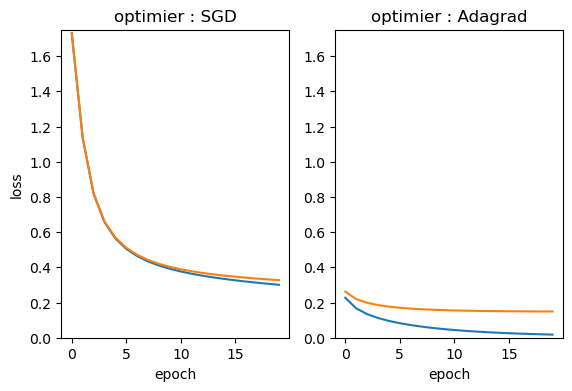

In [119]:
plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.ylim(0, 1.75)
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_train, label='train')
plt.plot(np.arange(Simple_sigmoid_SGD.epoch), Simple_sigmoid_SGD.loss_val, label='val')
plt.title('optimier : SGD')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(132)
plt.ylim(0, 1.75)
plt.plot(np.arange(Simple_sigmoid_Adagrad.epoch), Simple_sigmoid_Adagrad.loss_train, label='train')
plt.plot(np.arange(Simple_sigmoid_Adagrad.epoch), Simple_sigmoid_Adagrad.loss_val, label='val')
plt.title('optimier : Adagrad')
plt.xlabel('epoch')

plt.show();

参考書通りの結果となった。  
Adagradがいかに有能か認識できた。